In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset\Testing\glioma_tumor\image(1).jpg
dataset\Testing\glioma_tumor\image(10).jpg
dataset\Testing\glioma_tumor\image(100).jpg
dataset\Testing\glioma_tumor\image(11).jpg
dataset\Testing\glioma_tumor\image(12).jpg
dataset\Testing\glioma_tumor\image(13).jpg
dataset\Testing\glioma_tumor\image(14).jpg
dataset\Testing\glioma_tumor\image(15).jpg
dataset\Testing\glioma_tumor\image(16).jpg
dataset\Testing\glioma_tumor\image(17).jpg
dataset\Testing\glioma_tumor\image(18).jpg
dataset\Testing\glioma_tumor\image(19).jpg
dataset\Testing\glioma_tumor\image(2).jpg
dataset\Testing\glioma_tumor\image(20).jpg
dataset\Testing\glioma_tumor\image(21).jpg
dataset\Testing\glioma_tumor\image(22).jpg
dataset\Testing\glioma_tumor\image(23).jpg
dataset\Testing\glioma_tumor\image(24).jpg
dataset\Testing\glioma_tumor\image(25).jpg
dataset\Testing\glioma_tumor\image(26).jpg
dataset\Testing\glioma_tumor\image(27).jpg
dataset\Testing\glioma_tumor\image(28).jpg
dataset\Testing\glioma_tumor\image(29).jpg
dataset\Test

In [3]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

In [4]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

In [5]:
X_train = []
Y_train = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [6]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape


(3264, 150, 150, 3)

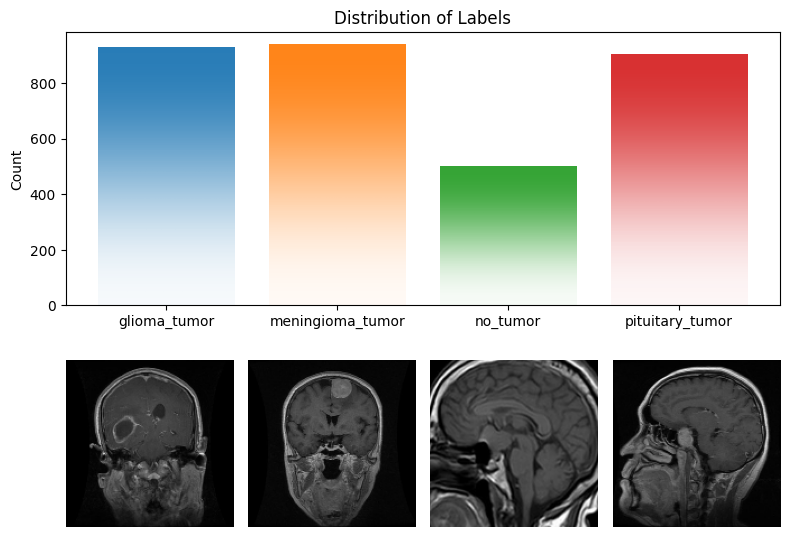

In [7]:
label_counts = {label: np.sum(Y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if Y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


In [11]:
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



83683744/83683744 [==============================] - 18s 0us/step



In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'] 

In [14]:
# Tensorboard callback for logging training metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [15]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10


83/83 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.7552
Epoch 1: val_accuracy improved from -inf to 0.28912, saving model to efficientnetB0.keras
83/83 [==============================] - 322s 4s/step - loss: 0.7353 - accuracy: 0.7552 - val_loss: 5.1265 - val_accuracy: 0.2891 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.9062
Epoch 2: val_accuracy improved from 0.28912 to 0.82653, saving model to efficientnetB0.keras
83/83 [==============================] - 298s 4s/step - loss: 0.3187 - accuracy: 0.9062 - val_loss: 0.8418 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9345
Epoch 3: val_accuracy did not improve from 0.82653
83/83 [==============================] - 296s 4s/step - loss: 0.2248 - accuracy: 0.9345 - val_loss: 7.9633 - val_accuracy: 0.2687 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - E

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

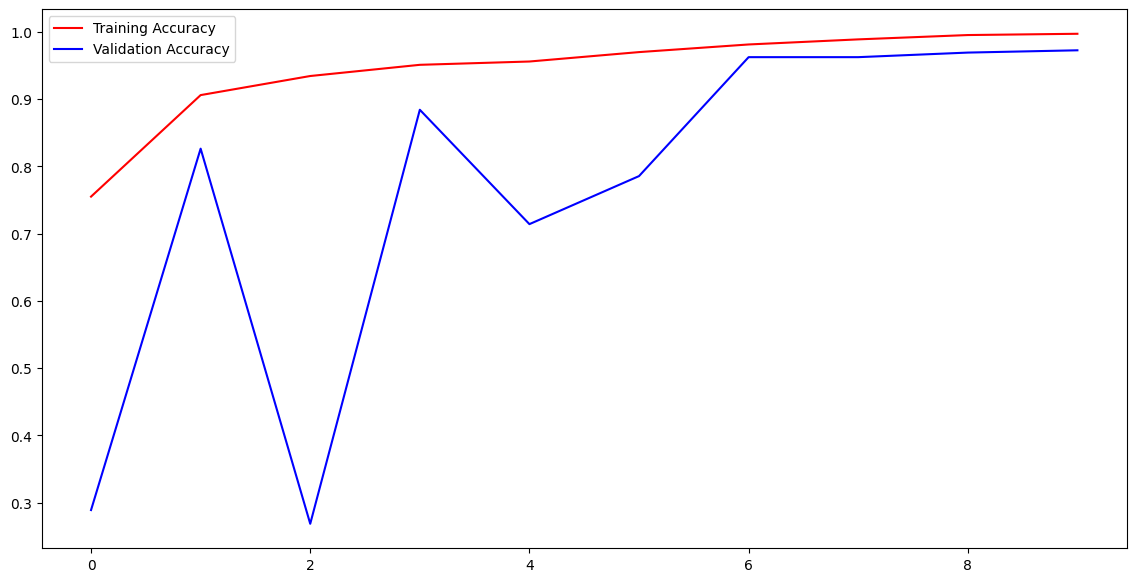

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

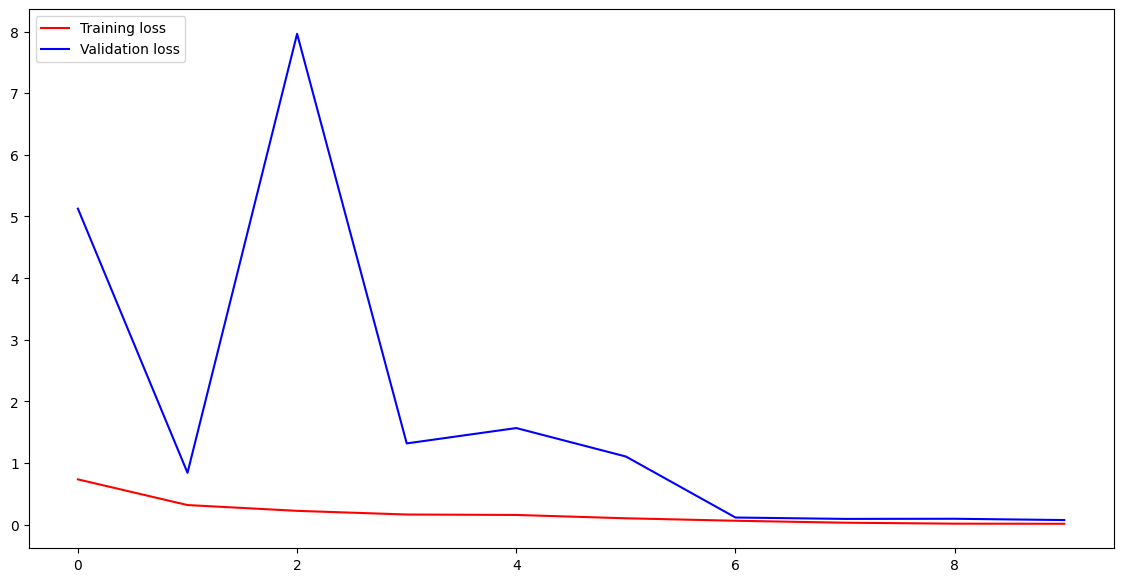

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [19]:
# Save the trained model
model.save(r'C:\MY LEARNING\Major Project\XceptionModel.keras')

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

11/11 [==============================] - 5s 485ms/step - loss: 0.1464 - accuracy: 0.9633
Test Loss: 0.14641278982162476
Test Accuracy: 0.963302731513977


In [22]:
# Load the saved model
from tensorflow.keras.models import load_model
loaded_model = load_model(r'C:\MY LEARNING\Major Project\XceptionModel.keras')


11/11 [==============================] - 7s 527ms/step


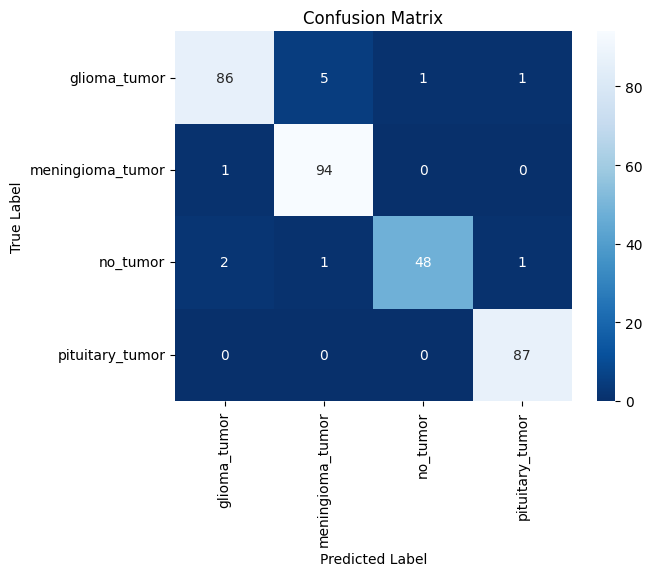

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        93
           1       0.94      0.99      0.96        95
           2       0.98      0.92      0.95        52
           3       0.98      1.00      0.99        87

    accuracy                           0.96       327
   macro avg       0.97      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



In [25]:
img = cv2.imread('dataset/Training/meningioma_tumor/m (67).jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [26]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

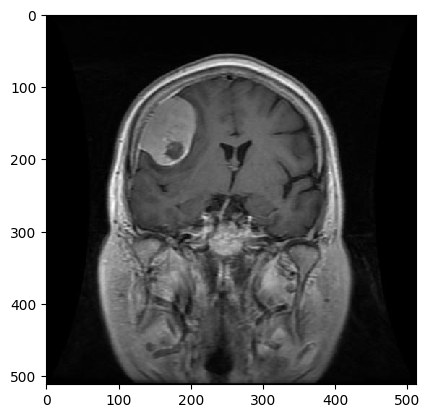

In [27]:
from tensorflow.keras.preprocessing import image
img = image.load_img('dataset/Training/meningioma_tumor/m (67).jpg')
plt.imshow(img,interpolation='nearest')
plt.show()

In [28]:
a=model.predict(img_array)
indices = a.argmax()
indices


1/1 [==============================] - 0s 101ms/step


1

1/1 [==============================] - 0s 89ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 100.00%



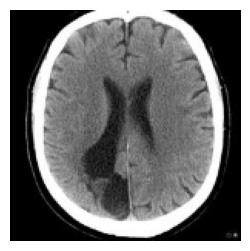

In [36]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()